In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
g = 9.8        # acceleration due to gravity
h0 = 1.0       # initial height
v0 = 10.0      # initial velocity

# True (analytical) solution h(t) = h0 + v0*t - 0.5*g*t^2
def true_solution(t):
    return h0 + v0*t - 0.5*g*(t**2)

# Generate some time points
t_min, t_max = 0.0, 10.0
N_data = 30
t_data = np.linspace(t_min, t_max, N_data)

# Generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

In [ ]:
class PINN(nn.Module):
    def __init__(self, n_hidden=20):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, t):
        return self.net(t)

# Instantiate the model
model = PINN(n_hidden=20)

In [ ]:
def derivative(y, x):
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

In [ ]:
def physics_loss(model, t):
    t.requires_grad_(True)
    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)
    dh_dt_true = v0 - g * t
    loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
    return loss_ode

def initial_condition_loss(model):
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()

def data_loss(model, t_data, h_data):
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lambda_data = 0.1
lambda_ode  = 1.0
lambda_ic   = 1.0
num_epochs = 4000
print_every = 200

In [ ]:
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model)
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic
    loss.backward()
    optimizer.step()
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")

Epoch 200/4000, Total Loss = 3978.207031, Data Loss = 20628.130859, ODE Loss = 1915.250366, IC Loss = 0.143552
Epoch 400/4000, Total Loss = 3106.242920, Data Loss = 15916.622070, ODE Loss = 1514.576416, IC Loss = 0.004157
Epoch 600/4000, Total Loss = 2454.345459, Data Loss = 12899.066406, ODE Loss = 1164.434814, IC Loss = 0.004189
Epoch 800/4000, Total Loss = 1912.837646, Data Loss = 9486.984375, ODE Loss = 964.136841, IC Loss = 0.002492
Epoch 1000/4000, Total Loss = 1463.558105, Data Loss = 7329.906738, ODE Loss = 730.567200, IC Loss = 0.000203
Epoch 1200/4000, Total Loss = 1101.386475, Data Loss = 5481.454102, ODE Loss = 553.076843, IC Loss = 0.164209
Epoch 1400/4000, Total Loss = 811.772705, Data Loss = 4063.938477, ODE Loss = 405.377716, IC Loss = 0.001074
Epoch 1600/4000, Total Loss = 572.709656, Data Loss = 3047.082520, ODE Loss = 267.935852, IC Loss = 0.065567
Epoch 1800/4000, Total Loss = 421.920868, Data Loss = 1872.989746, ODE Loss = 234.583237, IC Loss = 0.038670
Epoch 2000/

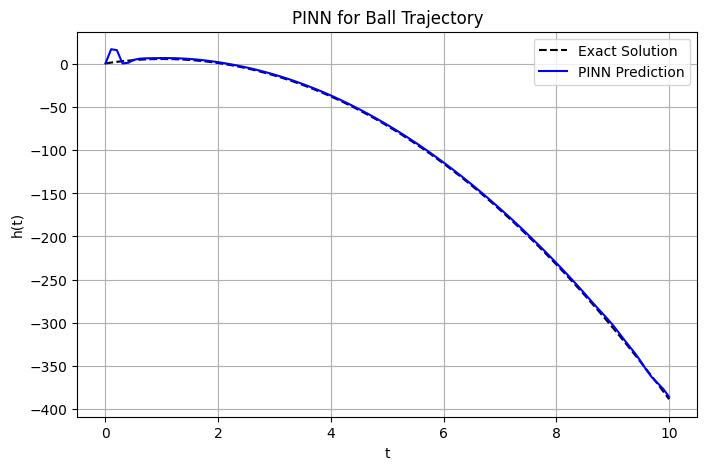

In [ ]:
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

h_true_plot = true_solution(t_plot)

plt.figure(figsize=(8, 5))
#plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()